# Introduction

In the following notebook, I will be modeling Airbnb Listings data to create a price predictor to better understand the data

**Read in libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set notebook preferences**

In [2]:
#Set options for pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Set options for numpy
np.set_printoptions(suppress=True)

#Set visualization preferences
plt.style.use('Solarize_Light2')

#Surpress warnings
import warnings
warnings.simplefilter('ignore')

#Set path to write visuals
viz_path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Visualizations\Modeling'

#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Data\03_Processed'

**Read in data**

In [3]:
#Read in training data and labels
df = pd.read_csv(path + '/2020_0715_Listings_Processed.csv', index_col=0)

**Data Overview**

In [4]:
#Display data and shape
print('Data shape: {}\n'.format(df.shape))
display(df.head())

Data shape: (116180, 12)



,accommodates,amenities_count,bedrooms,beds,cleaning_fee,guests_included,neighbourhood_cleansed_encoded,price,security_deposit,room_type,property_type,bed_type
0,3,26,1.000,2.000,100.000,2,253.859,170.000,100.000,Entire home/apt,Apartment,Real Bed
1,2,16,1.000,1.000,50.000,1,209.222,65.000,200.000,Private room,Apartment,Real Bed
3,6,33,2.000,3.000,125.000,1,253.859,255.000,0.000,Entire home/apt,Apartment,Real Bed
4,3,34,1.000,2.000,50.000,2,215.286,139.000,0.000,Private room,Condominium,Real Bed
5,2,23,1.000,1.000,50.000,1,238.334,135.000,2.000,Private room,House,Real Bed


### Data Preparation

**Split data into training and test sets**

In [5]:
#Seperate labels from data
X = df.drop('price', axis = 1)
y = df['price']

#Check
print('X shape:{}\ny shape:{}'.format(X.shape,y.shape))

X shape:(116180, 11)
y shape:(116180,)


In [6]:
#Import splitter
from sklearn.model_selection import train_test_split

#Split Data
X_train, X_test, y_train, y_test =  train_test_split(
                                    X,y, test_size = .2, random_state = 42)

#Check
print('Training data:{} | Training labels:{}'.format(X_train.shape,y_train.shape))
print('Test data:{} | Test labels:{}'.format(X_test.shape,y_test.shape))

Training data:(92944, 11) | Training labels:(92944,)
Test data:(23236, 11) | Test labels:(23236,)


# Model Development 

## Build Preprocessor

In [94]:
#Read in Libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict

#Init column transformer for data type
numeric_transformer = Pipeline([('scaler', MinMaxScaler())])
categorical_transformer = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])

#Subset numeric and cat features
num_features = X_train.select_dtypes(include=['int64','float64']).columns
cat_features = X_train.select_dtypes(include='object').columns

#Store column transform for pipeline
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_features),
                                              ('cat', categorical_transformer, cat_features)],
                                             n_jobs=-1,)

## Build pipeline with base model: DecisionTreeRegressor

In [8]:
#Init base model as regressor
regressors = DecisionTreeRegressor(random_state=12, max_depth=10)

#Init pipe
pipe = Pipeline([('preprocessor', preprocessor),
                ('model', regressors)])

**Make and Evaluate Predictions**

Base DecisionTreeRegressor Evaluation Metrics:
R2: 0.6779558155333093
MAE: 34.87246734250352 
MSE: 2454.6253628220547
RMSE: 49.54417587186263


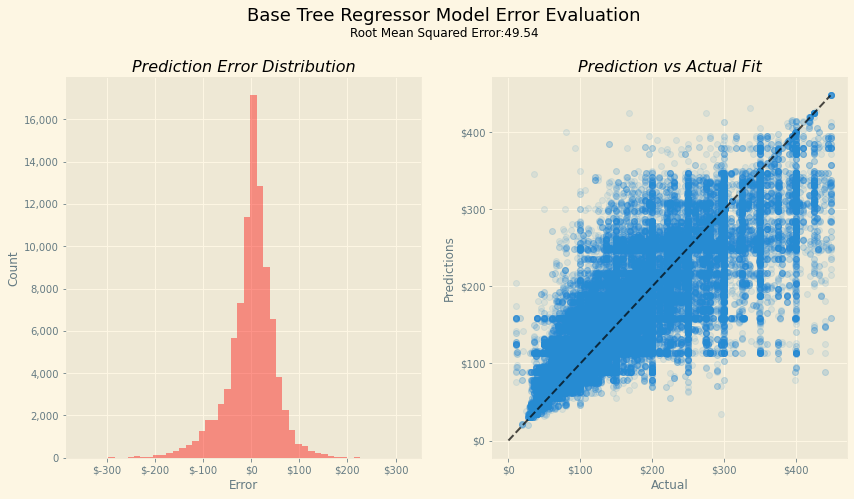

In [9]:
#Read in libraries from local machine
from Model_Evaluation import regression_metrics, prediction_error_df, prediction_fit_eval

#Implement model
preds = cross_val_predict(pipe, X_train,y_train, n_jobs=-1)

#Evaluate
base_metrics = regression_metrics('Base DecisionTreeRegressor', preds, y_train)

#View Error distribution and fit
base_errors = prediction_error_df(preds, y_train)
prediction_fit_eval(base_errors, model_name='Base Tree Regressor Model', rmse = base_metrics['rmse']);

#Save figure
plt.savefig(viz_path + '/base_model_pred_fit.png', bbox_inches='tight')

In [10]:
#Display error dataframe
display(base_errors.sort_values(by = 'error_%', ascending= False).head(10))

,predictions,actual,error,error_%
95835,204.123,10.000,194.123,1941.232
37594,174.477,10.000,164.477,1644.773
108368,158.708,10.000,148.708,1487.084
31737,158.708,10.000,148.708,1487.084
70617,158.563,10.000,148.563,1485.630
76296,158.563,10.000,148.563,1485.630
87218,158.563,10.000,148.563,1485.630
97983,158.563,10.000,148.563,1485.630
81099,158.441,10.000,148.441,1484.408
92207,158.441,10.000,148.441,1484.408


# Test Ensemble and Boosting Methods

In [11]:
#Import Libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

## Build initial pipeline

Goal: Test base model version of each Ensemble and Boosting method to evaluate performance on training data. Best performing model(according to RMSE) will be further tuned and deployed on test data.

In [12]:
#Create a list of model names to be used in a print funtion later when aggregating model evaluation metrics
model_names = [
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'XGBRegressor',
]

#Init models into a list to loop over in pipeline to evaluate all base model performances
regressors = [
    RandomForestRegressor(random_state = 42, n_jobs=-1,max_depth=10),
    GradientBoostingRegressor(random_state = 42,max_depth=10),
    XGBRegressor(random_state = 42, n_jobs=-1,max_depth=10)
]

**Build preliminary pipeline, evaluate results, and select model for futher development**

RandomForestRegressor Evaluation Metrics:
R2: 0.7186457981194944
MAE: 33.257328355188044 
MSE: 2144.4857357574087
RMSE: 46.308592461414854
GradientBoostingRegressor Evaluation Metrics:
R2: 0.8903955627414877
MAE: 19.15955577487306 
MSE: 835.4065825411906
RMSE: 28.903400881923748
XGBRegressor Evaluation Metrics:
R2: 0.9441781143084303
MAE: 11.228194405021263 
MSE: 425.4752081488148
RMSE: 20.627050398658913


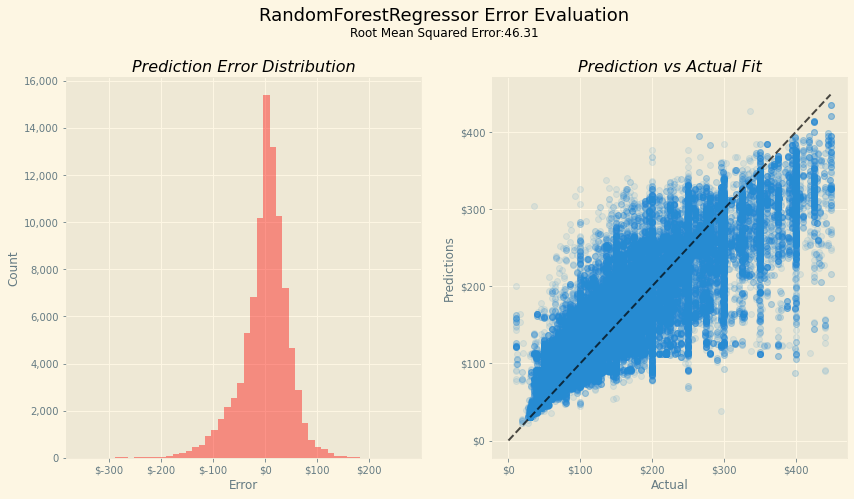

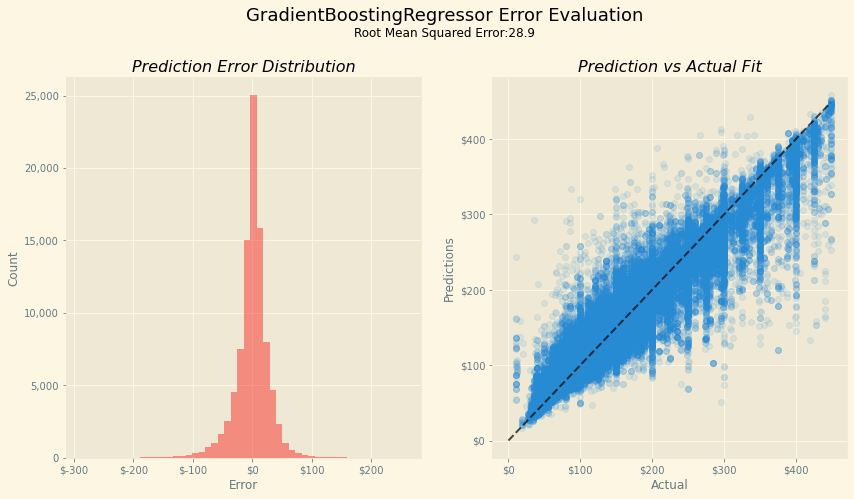

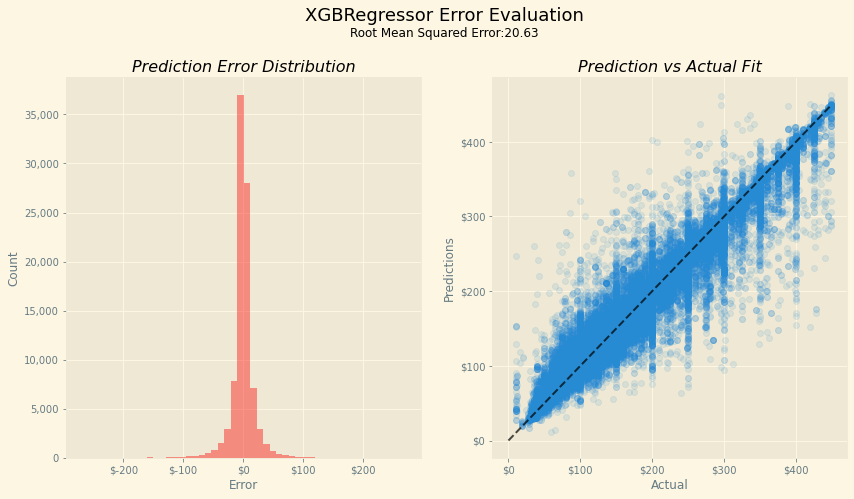

In [13]:
#Implement pipe that tests evaluation metrics for all regressors
for name,regressor in zip(model_names, regressors):
    pipe.steps.pop(1) #Delete previous model in pipeline
    pipe.steps.append(['model',regressor]) #Add new model

    predictions = cross_val_predict(pipe, X_train, y_train,cv=3, n_jobs=-1)
 
    #Evaluate
    metrics = regression_metrics(name,predictions, y_train, return_dict=True)
    error_df = prediction_error_df(predictions, y_train)
    prediction_fit_eval(error_df, model_name=name, rmse=metrics['rmse'])
    
    #Save error dist and prediction fit plot
    plt.savefig(viz_path + '/' + name + '_pred_fit.png', bbox_inches='tight')

# Tune Hyperparameters - XGBRegressor

**RandomSearch CV**

In [20]:
#Init libraries
from sklearn.model_selection import RandomizedSearchCV

#Set list with evaluation metrics for RandomizedSearchCV
scoring = ['r2','neg_mean_absolute_error','neg_mean_squared_error']

#Create list of model names for later loop
model_name = [
    'XGBRegressor',
    ]

#Init models 
regressor = [XGBRegressor()]

#Init parameters for RandomSearchCV evaluation to search over
parameters = [
    {'model__n_estimators':[250, 300, 350],
    'model__max_depth':[15, 20, 25],
    'model__learning_rate': [.01,.1],
    'model__random_state' : [42], 
    'model__n_jobs': [-1]}
]

In [21]:
#Create pipeline with parameter grid to search over base models(randomsearch cv)
for name, xgbr, parameter in zip(model_name, regressor, parameters):
    pipe.steps.pop(1) #Delete previous model in pipeline
    pipe.steps.append(['model',xgbr]) #Add new model
    
    reg = RandomizedSearchCV(pipe, param_distributions=parameter, n_jobs=-1, scoring=scoring, refit='neg_mean_squared_error')
    reg.fit(X_train, y_train)
    
    print("{} Random Search Results:".format(name))
    print('Avg RMSE:',np.mean(np.sqrt(-1 * (reg.cv_results_['mean_test_neg_mean_squared_error']))))
    print('Avg MAE:',np.mean(-1 * reg.cv_results_['mean_test_neg_mean_absolute_error']))
    r2 = np.mean(reg.cv_results_['mean_test_r2'])
    print('Avg R2:',r2)
    print("\n The best parameters across searched parameters:\n", reg.best_params_)
    print("========================================================")

XGBRegressor Random Search Results:
Avg RMSE: 20.146777993778876
Avg MAE: 10.666611389264917
Avg R2: 0.9439205327305944

 The best parameters across searched parameters:
 {'model__random_state': 42, 'model__n_jobs': -1, 'model__n_estimators': 350, 'model__max_depth': 15, 'model__learning_rate': 0.1}


In [31]:
#Store reg.best_estimator_
tuned_xgbr = reg.best_estimator_

#Print specs
print('Tuned XGBRegressor Pipeline:\n',tuned_xgbr)

Tuned XGBRegressor Pipeline:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['accommodates', 'amenities_count', 'bedrooms', 'beds', 'cleaning_fee',
       'guests_included', 'neighbourhood_cleansed_encoded',
       'security_deposit'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate

**Evaluate Fit**

In [34]:
#Get predictions
preds = cross_val_predict(tuned_xgbr, X_train, y_train, n_jobs=-1, cv = 5)

Tuned XGBRegressor Evaluation Metrics:
R2: 0.96747473921141
MAE: 4.949499943145972 
MSE: 247.90800118401881
RMSE: 15.745094511752503


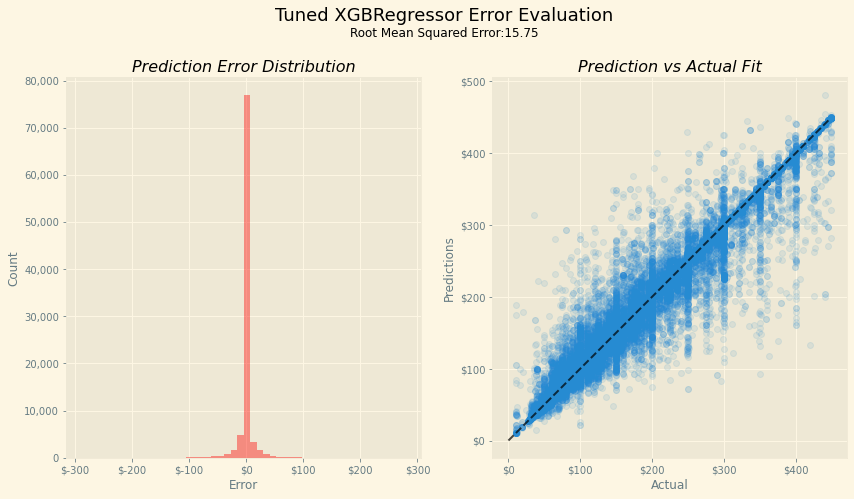

In [38]:
#Get stats and view error distribution/prediction fit eval
xgbr_metrics = regression_metrics('Tuned XGBRegressor', preds, y_train)
xgbr_error = prediction_error_df(preds, y_train)
prediction_fit_eval(xgbr_error, model_name='Tuned XGBRegressor', rmse=xgbr_metrics['rmse']),

#Save error dist and prediction fit plot
plt.savefig(viz_path + 'Tuned_XGBR_Error_Fit_Evaluation.png', bbox_inches='tight')

**View Feature Importances**

In [97]:
#Get feature names of transformed cat features
transformed_cats = tuned_xgbr['preprocessor'].transformers_[1][1]['encoder'].get_feature_names(cat_features).tolist()

#Combine original num feats with transformed cats
original_features = [*num_features, *transformed_cats]

In [59]:
#Get feature importances from regressor
feat_import = tuned_xgbr.named_steps['model'].feature_importances_

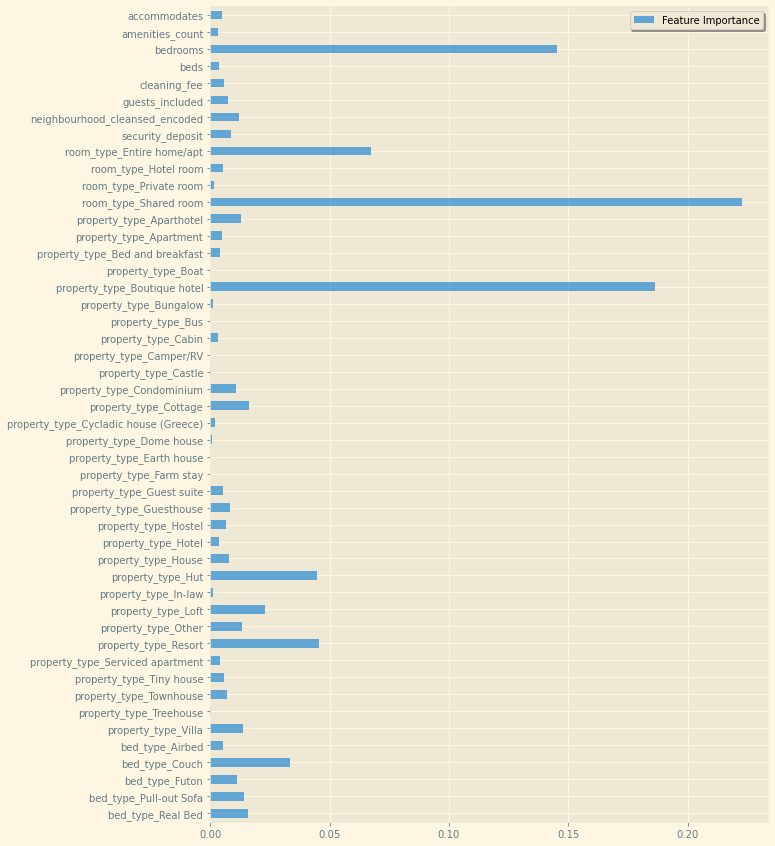

In [105]:
#Store in data frame with original_features as idnex
feature_importances = pd.DataFrame(feat_import, index=original_features,columns=['feature_importance'])

#Plot Feature Importance
f, ax = plt.subplots(figsize = (10,15), )
feature_importances.plot(kind = 'barh', ax=ax, alpha = .7)
ax.invert_yaxis()
ax.legend(['Feature Importance'], shadow = True, frameon = True)

**Save Tuned Model**

In [33]:
#Set path to save tuned_xgbr
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models'

#Write pipeline
import joblib
joblib.dump(tuned_xgbr, path + '/XGBR_Price_Predictor.pkl', compress = 1)

['C:\\Users\\kishe\\Documents\\Data Science\\Projects\\Python Projects\\In Progress\\Airbnb - San Francisco Listings Analysis\\Project_Codes\\04_Modeling\\Saved_Models/XGBR_Price_Predictor.pkl']

**Load Saved model**

# Deploy